<a href="https://colab.research.google.com/github/ParthikB/F.R.I.E.N.D.S/blob/master/FRIENDS_siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
'''
PROGRESS LADDER:

            Similarity Score between some person and F.R.I.E.N.D.S. Characters
                                          ^
                  Saved Facial Features Value of all the 6 characters
                                          ^
          A Model that will extract the facial feature information from the image
                                        

'''

'\nPROGRESS LADDER:\n\n            Similarity Score between some person and F.R.I.E.N.D.S. Characters\n                                          ^\n                  Saved Facial Features Value of all the 6 characters\n                                          ^\n          A Model that will extract the facial feature information from the image\n                                        \n\n'

# Importing Libraries

In [22]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import seaborn as sns
import cv2

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


# Downloading the Dataset

In [23]:
PATH = '/content'

train_data = datasets.CIFAR100(PATH, train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

test_data  = datasets.CIFAR100(PATH, train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

BATCH_SIZE = 64
CLASSES    = 100

trainSet = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
testSet  = torch.utils.data.DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [37]:
train_data

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /content
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

### Visualizing a sample

Batch Size : 64
tensor(64)


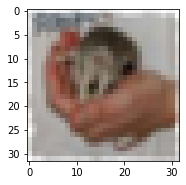

In [24]:
i = np.random.randint(BATCH_SIZE) # a random sample from the first batch
for batch in trainSet:
    print("Batch Size :", len(batch[0]))
    # batch --> one batch containing BATCH_SIZE samples
    x, y = batch[0][i], batch[1][i]
    break

CHANNELS, DIM, DIM = x.shape
TOTAL_PIXELS = DIM*DIM

t = x.numpy()


plt.subplot(1, 2, 1)
plt.imshow(np.rollaxis(t, 0, 3)) # Reshaping x from (1, DIM, DIM) --> (DIM, DIM, 1)
print(y)

# Defining the Network

In [0]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    '''
    Network Structure:

    input > 
    (1)Conv2D > (2)MaxPool2D > 
    (3)Conv2D > (4)MaxPool2D > 
    (5)Conv2D > (6)MaxPool2D > 
    (7)Linear > (8)LinearOut

    '''

    # Creating the convulutional Layers
    self.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

    self.flatten = None
    # Creating a Random dummy sample to get the Flattened Dimensions
    x = torch.randn(CHANNELS, DIM, DIM).view(-1, CHANNELS, DIM, DIM)
    x = self.convs(x)

    # Creating the Linear Layers
    self.fc1   = nn.Linear(self.flatten, 512)
    self.fc2   = nn.Linear(512, CLASSES)

  def convs(self, x):
    # Creating the MaxPooling Layers
    x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=(2, 2))

    if not self.flatten:
      self.flatten = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
    return x

  # FORWARD PASS
  def forward(self, x):

    x = self.convs(x)
    x = x.view(-1, self.flatten)
    sm = F.relu(self.fc1(x))
    # x = F.softmax(self.fc2(sm), dim=1)
    x = self.fc2(sm)

    return x, sm

In [0]:
def train(net, train_set, loss_log=[], EPOCHS=5, LEARNING_RATE=0.001, BATCH_SIZE=32):
  print('Initiating Training..')  
  loss_func = nn.CrossEntropyLoss()

  # Iteration Begins
  for epoch in tqdm_notebook(range(EPOCHS)):
    # Iterate over every sample in the batch
    for data in tqdm_notebook(trainSet, desc=f'Iteration > {epoch}/{EPOCHS} : ', leave=False):
        x, y = data
        net.zero_grad()
        
        #Compute the output
        output, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))
        
        # Compute Loss
        loss = loss_func(output, y.to(device))
        
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()
 
    loss_log.append(loss)
  
  return loss_log



def test(net, test_set, find_accuracy=True):
  print('Initiating Testing..')
  correct = 0
  total   = 0
  sm_log = []

  with torch.no_grad():
    for data in tqdm_notebook(test_set):
      x, y = data

      # Prediction the TestSet Data
      prediction_in_batch, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))

      # ARGMAXing the predicted output
      for output in zip(prediction_in_batch, y, sm):
        pred_class, real_class, sm = output
        pred_class = torch.argmax(pred_class)

        sm_log.append([sm, real_class])

        total += 1
        if real_class == pred_class:
          correct += 1

  accuracy = (correct/total)*100
  print()
  print(f'Test Accuracy : {round(accuracy, 2)} %')
  return accuracy, sm_log

# Training

Initiating Training..



Initiating Testing..




Test Accuracy : 29.36 %
Total Epochs : 5


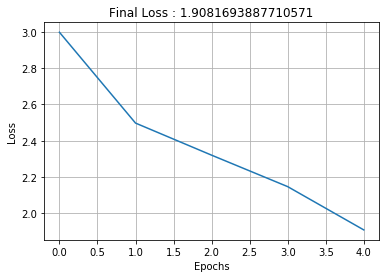

In [28]:
EPOCHS        = 5
LEARNING_RATE = 0.001
BATCH_SIZE    = BATCH_SIZE
CONTINUE_TRAINING = 0

if not CONTINUE_TRAINING:
  net = Net().to(device)
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  loss_log = []
  total_epochs = 0


total_epochs += EPOCHS
loss_log = train(net, trainSet, loss_log, EPOCHS, LEARNING_RATE, BATCH_SIZE)

plt.plot(loss_log)
plt.grid(1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Final Loss : {loss_log[-1]}')

accuracy, sm_log = test(net, testSet)

print(f'Total Epochs : {total_epochs}')

# Heatmap

In [0]:
def mean(list):
  return sum(list)/len(list)

# CREATING A DICT THAT CONTAINS THE RESPECTIVE SM
classes = {}

for data in (sm_log):
  sm, label = data
  label = label.numpy()
  sm = sm.cpu().numpy()
  
  try:
    classes[str(label)].append(sm)
  except:
    classes[str(label)] = [sm]


# FINDING THE MINIMUM SAMPLES to CLIP
clip = 1000
for i in classes.keys():
  clip = min(clip, len(classes[i]))


# CLIPPING ALL THE CLASSES SAMPLES TO THE MINIMUM
for i in classes.keys():
  classes[i] = classes[i][:clip]

# CREATING A MASTER IN ORDER
master = []
for c in sorted(classes.keys()):
  master.append(np.array(classes[c]))

# CREATING A MAP LIST TO PLOT
edist_log=[]
for class1 in master:
  class1 = torch.Tensor(class1.mean(axis=1))
  for class2 in master:
    class2 = torch.Tensor(class2.mean(axis=1))
    edist = F.pairwise_distance(class1.view(-1,  1), class2.view(-1,  1), keepdim = True).float().numpy()
    edist_log.append(edist.mean())

map = np.array(edist_log).reshape(10, 10)
sns.heatmap(map)

# Extra

In [0]:
from PIL import Image

In [0]:
# !wget https://pmctvline2.files.wordpress.com/2019/06/friends-rachel.jpg?w=620

rach1 = Image.open('/content/friends-rachel.jpg')
# rach = torch.Tensor(np.array(rach))

In [0]:
# !wget https://vignette.wikia.nocookie.net/friends/images/5/56/Friends-Rachel_Green-Jennifer_Aniston-younger_4.jpg/revision/latest/top-crop/width/300/height/300?cb=20190828233528

rach2 = Image.open('/content/rach2.jpg')

In [0]:
rach3 = Image.open('/content/rach3.jpg')
ross1 = Image.open('/content/ross1.jpg')


In [113]:
def get_sm(net, image):
  print('Initiating Testing..')

  with torch.no_grad():
    # for data in tqdm_notebook(test_set):
      # x, y = data
      image_arr = np.array(image)
      x = cv2.resize(image_arr, (DIM, DIM))
      x = torch.Tensor(x)

      # Prediction the TestSet Data
      prediction_in_batch, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))

  return sm


sm1 = get_sm(net, rach1)
sm2 = get_sm(net, rach2)
sm3 = get_sm(net, rach3)
sm4 = get_sm(net, ross1)

Initiating Testing..
Initiating Testing..
Initiating Testing..
Initiating Testing..


In [115]:
def get_sim_score(sm1, sm2):
  score = F.pairwise_distance(sm1.view(-1,  1), sm2.view(-1,  1), keepdim = True).float().cpu().numpy()
  return score.mean()

scores = [sm1, sm2, sm3, sm4]

for i in range(len(scores)):
  for j in range(i+1, len(scores)):
    print(f'sm{i+1}-sm{j+1} :', get_sim_score(scores[i], scores[j]))

sm1-sm2 : 65.65922
sm1-sm3 : 26.050785
sm1-sm4 : 58.884872
sm2-sm3 : 58.00042
sm2-sm4 : 47.418663
sm3-sm4 : 50.927483
